<a href="https://colab.research.google.com/github/daniellecd/portfolio/blob/master/Sensor_Quimico/Desafio_DataScience.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <span style="color:purple">Desafio</span>

### Análise de dados de sensores químicos

Autora: Danielle Calazans Dondoni [\[e-mail\]](mailto:'Danielle%20Calazans%20Dondoni'<danicalazans@outlook.com>)
                                  [\[linkedin\]](<https://www.linkedin.com/in/danielle-cd/>)

---

### Informações dos atributos

O conjunto de dados contém resultados médios de 5 sensores químicos de um dispositivo multisensor (PTXX.SX). O dispositivo estava localizado a nível da rua, dentro de uma cidade significativamente poluída. 

- Os dados foram registrados de março de 2004 a abril de 2005. 
- Valores ausentes são marcados com o valor -200. 
- A medida de outros sensores também está disponível e algumas podem ser redundantes. 

| ID | Descrição | Unidade|
| :-: | :-: | :-: |
|1| Date |(DD/MM/YYYY) | 
|2| Time | (HH.MM.SS) | 
|3| PT08.S1 (CO)  |  |
|4| NMHC Concentration | (mg/m³) |
|5| Benzene Concentration | (mg/m³) |
|6| PT08.S2 (NMHC) |  |
|7| NOx Concentration | (ppb) |
|8| PT08.S3 (NOx) |  |
|9| NO2 Concentration| (mg/m³) | 
|10| PT08.S4 (NO<sub>2</sub>) |  |
|11| PT08.S5 (O<sub>3</sub>) |  |
|12| Temperature |(°C)|
|13| Relative Humidity| (%) |
|14| AH Absolute Humidity |  |

### Identificação dos problemas

1) Definir uma estratégia para tratar os dados faltantes e *outliers*
2) Mensurar a correlação entre as variáveis
3) Identificar os horários de maior concentração de CO nas quartas-feiras
4) Avaliar a interferência das estações do ano
5) Criar um modelo de regressão para os dados do sensor PT08.S1 (CO), que mede a concentração de CO na atmosfera.

## Instalação e importação das bibliotecas necessárias

In [ ]:
# Instação dos pacotes necessários
!pip install ipywidgets
!pip install watermark
!pip install --pre -U pandas-profiling
!pip install missingno
!pip install lightgbm
!pip install xgboost
%load_ext watermark

In [ ]:
# Importação das bibliotecas para cálculos e manipulação dos dados
import numpy as np
import pandas as pd
import missingno as msno
import datetime as dt
import seaborn as sns
import pingouin as pg
from sklearn.impute import KNNImputer
from scipy.stats import kurtosis
from scipy.stats import skew
from pandas_profiling import ProfileReport

# Importação das bibliotecas para visualização de dados
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
%matplotlib inline

# Importação das bibliotecas dos modelos de machine learning
from sklearn.datasets import make_regression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from lightgbm import LGBMRegressor as LightGBM
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR as SupportVectorRegressor
from xgboost import XGBRegressor

# Importação das bibliotecas necessárias para cálculo de métricas
from sklearn import metrics 
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from statsmodels.tsa.seasonal import seasonal_decompose

# Importação das bibliotecas necessárias para o pré-processamento
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Silenciar avisos
import warnings
warnings.filterwarnings("ignore")

## Análise Exploratória dos Dados (EDA)

In [ ]:
# Visualização da configuração do dataset
raw = pd.read_csv('qualidade_do_ar.csv')
raw.head(2)

,,,,Date;Time;PT08.S1(CO);NMHC(GT);C6H6(GT);PT08.S2(NMHC);NOx(GT);PT08.S3(NOx);NO2(GT);PT08.S4(NO2);PT08.S5(O3);T;RH;AH
10/03/2004;18.00.00;1360;150;11,9;1046;166;1056;113;1692;1268;13,6;48,9;0,7578.0
10/03/2004;19.00.00;1292;112;9,4;955;103;1174;92;1559;972;13,3;47,7;0,7255.0


Conforme observado no dataframe denominado por 'raw', o *dataset* é composto por uma coluna de data ['Date'] no formato dia/mês/ano, colunas separados por ponto e vírgula (';') e decimais separados por vírgula (','), representados por um espaçamento. Na descrição dos dados consta a informação de que os valores faltantes foram substituídos por '-200'. 

Dada as considerações, a nova leitura do conjunto de dados irá considerar estes parâmetros.

In [ ]:
# Leitura e visualização do dataset
df = pd.read_csv('qualidade_do_ar.csv',
                 na_values = '-200',
                 sep = ';',
                 decimal = ',',
                 parse_dates = ['Date'],
                 dayfirst=True,
                 infer_datetime_format = True)
df.head(5)

,Date,Time,PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,2004-03-10,18.00.00,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578
1,2004-03-10,19.00.00,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255
2,2004-03-10,20.00.00,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502
3,2004-03-10,21.00.00,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867
4,2004-03-10,22.00.00,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888


### Utilização do pandas profilling

A análise inicial do dataset foi realizada mediante uso da biblioteca pandas profilling, que permite obter informações descritivas e de estatística sobre os dados de forma quase imediata. 

Os gráficos e resultados do pandas-profilling permitiram uma avaliação geral do conjunto de dados. Para cada variável é disponibilizado um conjunto de informações, como o valor mínimo, máximo, médio, divisão de quartis, assimetria e curtose. Também há informações sobre o tipo das variáveis, histogramas, presença de valores nulo e correlações.

Destaca-se ainda a geração de um relatório em html (disponível no repositório), que facilita o compartilhamento, acesso e compreensão dos dados. 

Informações sobre a documentação podem ser obtidas no seguinte [\[link\]](<https://pandas-profiling.github.io/pandas-profiling/docs/master/rtd/#>)

In [ ]:
# Geração do relatório para ser visualizado no próprio ambiente Colab/Jupyter 
profile = ProfileReport(df, title='Qualidade do ar', explorative=True, progress_bar=False)
#profile.to_notebook_iframe()

#Exportação do relatório em html
profile.to_file(output_file='Qualidade_do_ar.html')

Para os dados sem tratamento, não serão reproduzidos neste notebook todas as informações já disponibilizadas no relatório.

### Tratamento dos dados ausentes e *outliers*

In [ ]:
# Impressão das informações básicas: tamanho do dataset, dados faltantes, nulos e duplicados
print('O dataset possui {} linhas, {} colunas, {} dados faltantes e {} dados duplicados.'.format(df.shape[0], df.shape[1], (df.isnull().sum().sum()), (df.isna().sum().sum()), df.duplicated().sum()))

O dataset possui 9357 linhas, 14 colunas, 15018 dados faltantes e 15018 dados duplicados.


In [ ]:
# Verificando o percentual de valores nulos por coluna
(df[df.columns[df.isna().any()]].isna().sum() / df.shape[0]).round(4) * 100 

PT08.S1(CO)       3.91
NMHC(GT)         90.23
C6H6(GT)          3.91
PT08.S2(NMHC)     3.91
NOx(GT)          17.52
PT08.S3(NOx)      3.91
NO2(GT)          17.55
PT08.S4(NO2)      3.91
PT08.S5(O3)       3.91
T                 3.91
RH                3.91
AH                3.91
dtype: float64

Observa-se a igualdade no valor percentual de dados nulos das colunas com dados dos sensores (incluíndo todos os PTXX.X, temperatura, umidade relativa e umidade absoluta). Uma visualização gráfica dos dados faltantes é obtido com a biblioteca missingno.

Informações sobre a documentação podem ser obtidas seguinte  [\[link\]](<https://github.com/ResidentMario/missingno>)

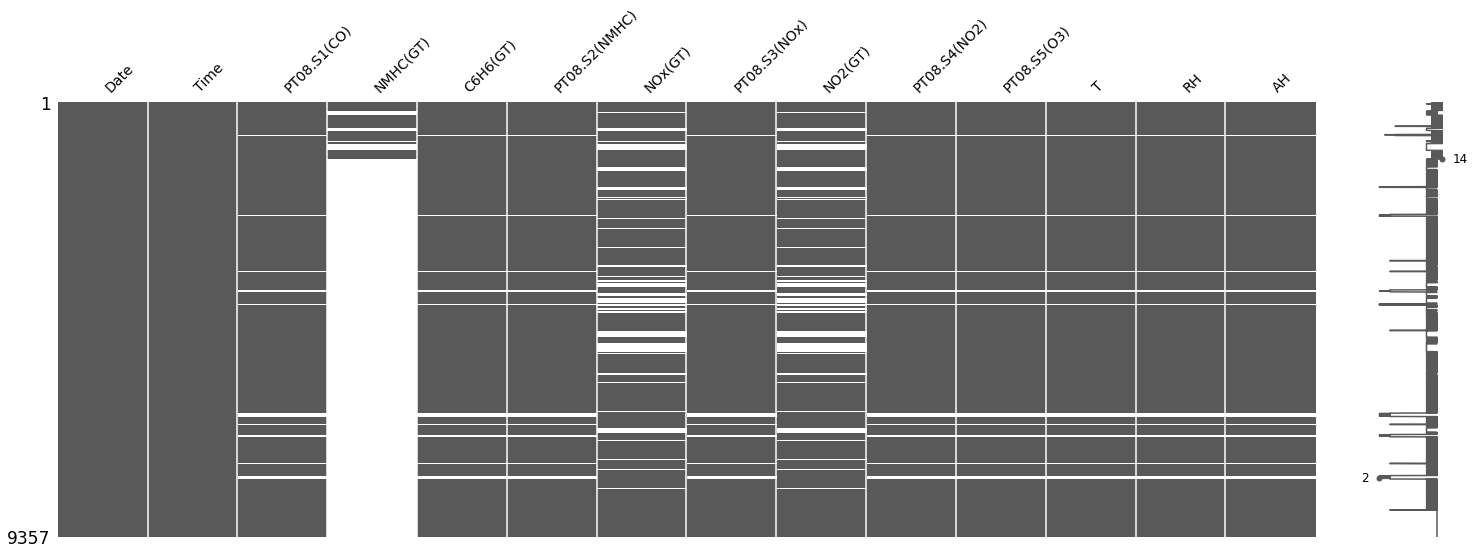

In [ ]:
# Matriz dos dados faltantes
msno.matrix(df,figsize=(25,8), color=(0.35, 0.35, 0.35), fontsize=14);

Pode-se supor que que os dados de 9 (nove) colunas ('PT08.S1(CO)', 'PT08.S3(NOx)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH') não foram obtidos por alguma falha no dispositivo multisensor, podendo estes dados ser classificados como *Missing at Random* (MAR). As possibilidade de tratamento dos dados faltantes incluem, mas não se limitam a:

- Remover as linhas ou colunas que contém dados nulos (df.dropna)

- Preenchimento das linhas e colunas com um valor constante ou ainda os dados de média, moda, mediana ou valor anterior e posterior (df.fillna)

- Preenchimento das linhas e colunas com um valor obtido pela classe KNNImputer

- Preenchimento das linhas e colunas com um valor obtido pela classe IterativeImputer

Vale observar que a maior parte dos dados nulos são atribuídos a uma mesma hora de observação (linhas). Neste caso, também foram considerados o resultado obtido após exclusão prévia dessas linhas.

Outro fator a ser considerado é a presença de *outliers*, identificados e removidos por métodos estatíticos. Para essa etapa foram realizados o cálculo do IQR, dado pela diferença entre o terceiro e o primeiro quartil. Resultados com valor abaixo de (Q1 - 1.5 * IQR) e acima de (Q3 + 1.5 * IQR) - correspondentes a aproximadamente |2,7 σ|, foram considerados como outliers e os dados foram removidos.

Dessa forma, foram pensados 6 cenários diferentes para o preenchimento dos dados, cada qual com 10 formas distintas de inserir os dados. Para avaliar os resultados, foram utilizados principalmente os resultados gráfico de dispersão, histograma e atributos estatíticos. A sequência das operações está descrita com mais detalhes nos notebooks nomeados de **Primeiro_cenario.ipynb** a **Sexto_cenário.ipynb**, apresentados à parte para melhor organização e comentados no próximo tópico.

Apenas o método escolhido como o de melhor desempenho será mostrado nesse notebook.

### Escolha do método para tratamento dos dados

- De forma geral, para este conjunto de dados, o preenchimento com média, mediana e moda altera signficativamente a forma dos histogramas e diagramas dispersão, que apresentaram maior heterogeneidade e menor correlação entre as variáveis quando utilizados tais métodos.

- Por análise do Primeiro_cenário e Quarto_cenario, fica evidente a necessidade de identificar e remover os outliers.

- Para o Segundo_cenario e Quinto_cenario, na qual a remoção dos *outliers* foi realizada em todo o *dataframe* antes de tratar os dados nulos, é demonstrada a ineficácia dessa estratégia.

- O Terceiro_cenario e Sexto_cenario fornecem resultados mais consistentes, sendo no Terceiro_cenario observados menores desvios padrão.

- Um tratamento de dados menos refinado, como a exclusão de todas as linhas que contém valor nulo, não parece inicialmente uma estratégia ruim ao analisar apenas os valores de média, desvio padrão e interpretação gráfica. No entanto, ao executar esse passo há uma perda de quase 30% dos dados disponíveis para análise, o que poderá impactar negativamente no desempenho do modelo de *machine learning* quando comparado com outra alternativa.

- Nota: Os resultados obtidos pelo INterativeImputer também parecem promissores, mas observou-se que para as variáveis NOx(GT) e NO<sub>2</sub>(GT) - que compreendem a maior quantidade de dados faltantes - obteve-se resultado negativo mesmo com exclusão dos *outliers*. Esses valores não tem significado visto que se tratam de concentrações de gases. Talvez um ajuste nos parâmetros dessa classe possa melhorar ainda mais os resultados, no entanto não será abordado nesta análise.

**Portanto, dentre as possibilidade avaliadas, o terceiro cenário com preenchimento feito por KNNImputer foi o escolhido.**

### Terceiro_cenario: Preenchimento com KNNImputer

##### Preenchimento dos dados faltantes

Para realizar o preenchimendo dos dados com o algoritmo KNNImputer é necessário que as variáveis estejam com o tipo adequado, isto é, não pode haver no *dataframe* os tipos data ou objeto. Nos cenários apresentados a exclusão destas colunas foi feita antes, no entanto, para não perder estas informações - que serão necessárias posteriormente, será necessário trabalhar com dois dataframes e depois juntá-los (*join*) com base no índice da coluna T.

A coluna ['NMHC(GT)'] também será exluída por conter mais de 90% de de dados faltantes.

Outras informações como Dia do Ano e Dia da semana serão incluidas nessa etapa para não ter que reverter a conversão da coluna ['Date'].

In [ ]:
# Etapas para execução do preenchimento dos dados
df1 = df.copy()
df1 = df1.drop(['NMHC(GT)'], axis = 1)

imputer = KNNImputer(n_neighbors=5, weights="uniform")

df_knn = df1[['PT08.S1(CO)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)',
             'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH']]

index = df_knn[df_knn['T'].isnull()].index

df_knn = pd.DataFrame(imputer.fit_transform(df_knn), 
                      columns = ['PT08.S1(CO)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)',
                                 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH'], index = df_knn.index)

# Resultados ausentes preenchidos - conferindo a tabela
df_knn.head() 

,PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,1360.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578
1,1292.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255
2,1402.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502
3,1376.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867
4,1272.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888


In [ ]:
# Juntando os dois dataframes e avaliando se os dados estão corretos
df_join = pd.merge(df_knn, df, left_index=True, right_index=True, how='outer')

#df_join.head().columns
# O subscrito "_x" é referente aos dados preenchidos pelo knn

Antes de excluir as colunas excedentes, uma rápida verificação de linhas aleatórias.
Foram escolhidas as linhas 123, 525, 890 e 5432 e os resultados comparados

Conforme verificação, ficou comprovado que a junção das tabelas ocorreu de forma correta. Sendo necessário agora executar a exclusão do que for desnecessário ('col_y')

In [ ]:
#df_join.iloc[[123]].T
#df_join.iloc[[525]].T
#df_join.iloc[[890]].T
#df_join.iloc[[5432]].T

In [ ]:
# Exclusão das colunas excedentes e avaliação dos dados resultantes
df2 = df_join.drop(['PT08.S1(CO)_y', 'NMHC(GT)','C6H6(GT)_y', 'PT08.S2(NMHC)_y', 
                    'NOx(GT)_y', 'PT08.S3(NOx)_y', 'NO2(GT)_y', 'PT08.S4(NO2)_y', 
                    'PT08.S5(O3)_y', 'T_y', 'RH_y', 'AH_y'], axis = 1)

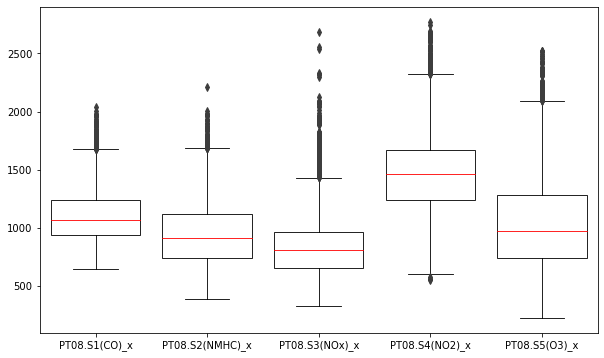

In [ ]:
# Visualização dos outliers
from matplotlib import rcParams
rcParams['figure.figsize'] = (10, 6)
color = {
    'boxprops':{'facecolor':'none', 'edgecolor':'black'},
    'medianprops':{'color':'red'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'}
}
sns.boxplot(data=df2[['PT08.S1(CO)_x', 'PT08.S2(NMHC)_x','PT08.S3(NOx)_x', 'PT08.S4(NO2)_x','PT08.S5(O3)_x']], linewidth=0.85, **color);

### Remoção dos outliers

In [ ]:
# Cálculo da variação interquartil (IQR)
cols = ['PT08.S1(CO)_x', 'C6H6(GT)_x', 'PT08.S2(NMHC)_x', 'NOx(GT)_x',
       'PT08.S3(NOx)_x', 'NO2(GT)_x', 'PT08.S4(NO2)_x', 'PT08.S5(O3)_x', 'T_x',
       'RH_x', 'AH_x']

Q1_df2 = df2[(cols)].quantile(0.25)
Q3_df2 = df2[(cols)].quantile(0.75)
IQR_df2 = Q3_df2 - Q1_df2

# Aplicação da fórmula para remoção dos outliers
df_tratado = df2[~((df2[(cols)] < (Q1_df2 - 1.5 * IQR_df2)) | (df2[(cols)] > (Q3_df2 + 1.5 * IQR_df2))).any(axis=1)] 

df_tratado.describe().T

,count,mean,std,min,25%,50%,75%,max
PT08.S1(CO)_x,8368.0,1076.484567,180.534447,667.0000,938.0000,1053.000000,1192.0000,1674.0000
C6H6(GT)_x,8368.0,9.109940,5.753573,0.5000,4.5000,7.900000,12.6000,28.2000
PT08.S2(NMHC)_x,8368.0,912.602934,222.036191,440.0000,739.0000,896.000000,1069.0000,1509.0000
NOx(GT)_x,8368.0,196.807559,139.682309,2.0000,89.0000,159.000000,267.0000,632.0000
PT08.S3(NOx)_x,8368.0,837.325922,203.051625,360.0000,688.0000,820.000000,965.0000,1429.0000
NO2(GT)_x,8368.0,103.681861,40.398382,2.0000,73.0000,101.000000,129.0000,229.0000
PT08.S4(NO2)_x,8368.0,1437.727132,315.448007,601.0000,1230.0000,1455.000000,1648.0000,2319.0000
PT08.S5(O3)_x,8368.0,979.211170,328.159388,288.0000,734.0000,942.000000,1200.2000,2066.0000
T_x,8368.0,18.774969,8.769702,-1.9000,12.4000,18.317829,24.8000,42.6000
RH_x,8368.0,48.531306,17.145864,9.2000,35.3000,48.700000,61.5000,88.7000


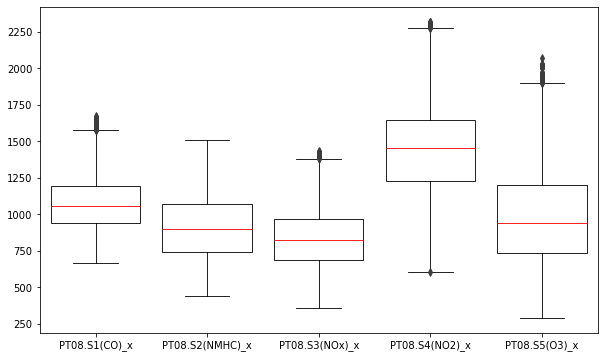

In [ ]:
# Após remoção dos outliers
from matplotlib import rcParams
rcParams['figure.figsize'] = (10, 6)
color = {
    'boxprops':{'facecolor':'none', 'edgecolor':'black'},
    'medianprops':{'color':'red'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'}
}
sns.boxplot(data=df_tratado[['PT08.S1(CO)_x', 'PT08.S2(NMHC)_x','PT08.S3(NOx)_x', 'PT08.S4(NO2)_x','PT08.S5(O3)_x']], linewidth=0.85, **color);

### Diagrama de dispersão - Dados tratados

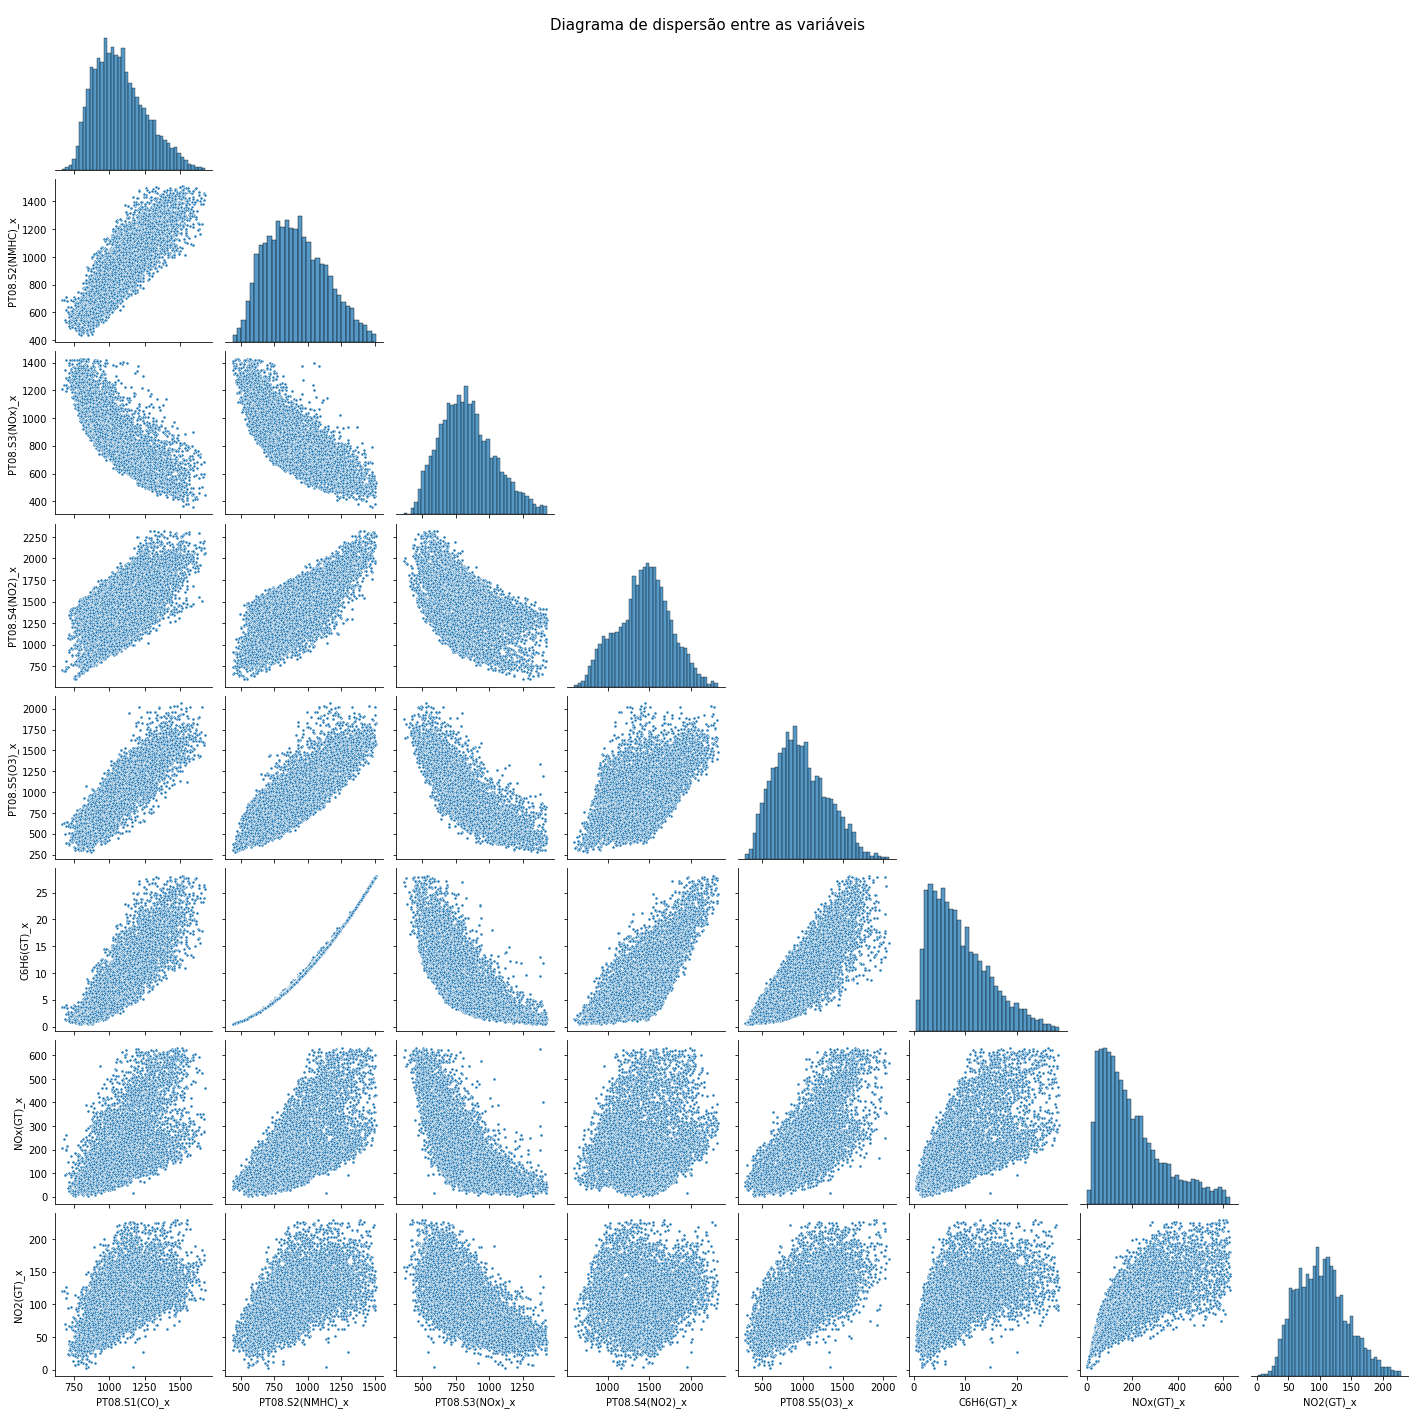

In [ ]:
# Análise gráfica - diagrama de dispersão
ax = sns.pairplot(df_tratado[['PT08.S1(CO)_x', 'PT08.S2(NMHC)_x', 'PT08.S3(NOx)_x', 'PT08.S4(NO2)_x',
                  'PT08.S5(O3)_x', 'C6H6(GT)_x', 'NOx(GT)_x', 'NO2(GT)_x']],
             plot_kws=dict(marker='.'),
             corner=True)
ax.fig.suptitle('Diagrama de dispersão entre as variáveis', fontsize=15)
plt.show()

### Matriz de correlação - Dados tratados

A matriz de correlação de Pearson calcula a associação linear entre variáveis contínuas, indicando o quanto a relação entre as variáveis podem ser descrita por uma reta. A interpretação destes dados pode ser feita da seguinte maneira:

| 0.9 a 1.0 | = correlação muito forte

| 0.7 a 0.9 | = correlação forte

| 0.5 a 0.7 | = correlação moderada

| 0.3 a 0.5 | = correlação fraca

| 0.0 a 0.3 | = correlação desprezível


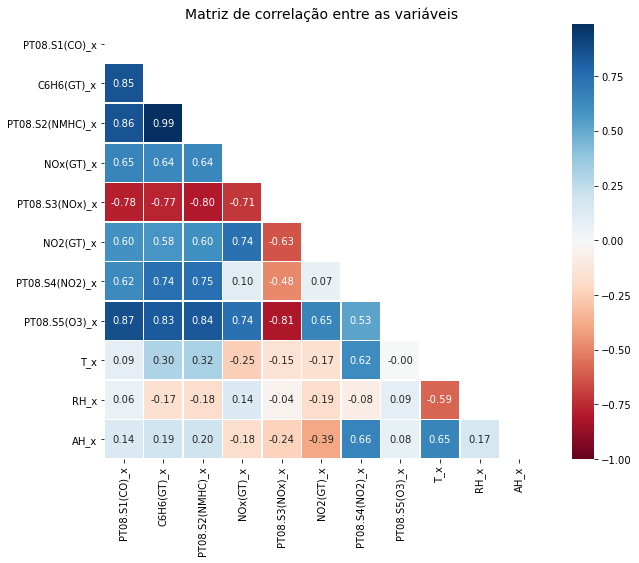

In [ ]:
# Exibição da matriz de correlação - Dados sem tratamento
plt.figure(figsize=(12,8))

# Definição da matrix de correlação
matrix_corr= df_tratado[['PT08.S1(CO)_x', 'C6H6(GT)_x', 'PT08.S2(NMHC)_x', 'NOx(GT)_x',
       'PT08.S3(NOx)_x', 'NO2(GT)_x', 'PT08.S4(NO2)_x', 'PT08.S5(O3)_x', 'T_x',
       'RH_x', 'AH_x']].corr()

# Visualização dos elementos abaixo da diagonal principal
mask = np.zeros_like(matrix_corr)
mask[np.triu_indices_from(mask)] = True

# Exibição gráfica
ax = sns.heatmap(matrix_corr, mask=mask, cmap = 'RdBu', fmt='.2f', square=True, annot=True, vmin=-1, linewidths=.5)
plt.title('Matriz de correlação entre as variáveis', fontsize=14)
plt.show()

Em relação à variável-alvo PT08.S1(CO), temos que:

- As variáveis 'PT08.S5(O3)_x', 'PT08.S2(NMHC)_x', 'C6H6(GT)_x', PT08.S3(NOx)_x apresentam forte correlação 
- As variáveis 'NOx(GT)_x','NO2(GT)_x' e  'PT08.S4(NO2)_x' apresentam moderada correlação 

Também é observado que as colunas C6H6(GT) e PT08.S2(NMHC) apresentam correlação muito forte (0,99). Portanto, uma das duas variáveis poderá ser excluída na etapa de modelagem. Nota-se ainda que 'PT08.S3(NOx)_x' apresenta correlação negativas com todas as variáveis.

A correlação de moderada a forte pbservada entre os sensores de NOx e NO2 é justificada pela interconversão de um composto no outro, atingidas as condiçoes necessárias.

## Influência das estações do ano

Em continuidade à resolução dos problemas identificados, será necessário desmembrar a coluna ['Date'] em novas colunas para realizar a definição das estações do ano e dias da semana.

##### Criação de dicionários e funções

In [ ]:
# Dicionário com os dias da semana
dict_dias={
    0: 'Segunda-feira', 
    1: 'Terça-feira', 
    2: 'Quarta-feira', 
    3: 'Quinta-feira', 
    4: 'Sexta-feira',
    5: 'Sábado', 
    6: 'Domingo'
} 

# Função para definir as estações - Hemisfério Norte
def estacoes_norte(x):
  if  x['Dia do ano'] < 80:
    return 'Inverno'
  elif 80 <= x['Dia do ano'] < 172:
    return 'Primavera'
  elif 172 <= x['Dia do ano'] < 266:
    return 'Verão'
  elif 266 <= x['Dia do ano'] < 356:
    return 'Outono'
  elif  x['Dia do ano'] >= 356:
    return 'Inverno'
  else:
    return 'error'

# Função para definir as estações - Hemisfério Sul
def estacoes_sul(x):
  if  x['Dia do ano'] < 80:
    return "Verão"
  elif 80 <= x['Dia do ano'] < 172:
    return 'Outono'
  elif 172 <= x['Dia do ano'] < 266:
    return 'Inverno'
  elif 266 <= x['Dia do ano'] < 356:
    return 'Primavera'
  elif  x['Dia do ano'] >= 356:
    return 'Verão'
  else:
    return 'error'


In [ ]:
# Extração de propriedades relacionadas à data
df3 = df_tratado.copy()

df3['Dia do ano']= df3['Date'].dt.dayofyear
df3['Dia']= df3['Date'].dt.day
df3['Mês']= df3['Date'].dt.month
df3['Ano']= df3['Date'].dt.year
df3['Dia da semana'] = df3['Date'].dt.weekday.map(dict_dias)
df3['Estacoes_Norte'] = df3.apply(estacoes_norte, axis=1)
df3['Estações_Sul'] = df3.apply(estacoes_sul, axis=1)

# Ajuste da coluna Hour (hora) 
df3['Time'] = df3['Time'].str[:2].astype('int')

#df3.head()

Para a análise seguintes, serão considerados os dados coletados durante 1 (um) ano, de **10/03/2004 a 09/03/2004**

In [ ]:
df3 = df3[df3['Date'] < '2005-03-10 00:00:00']

Como não há informação sobre o país no qual os dados foram obtidos, duas colunas com a estação do ano foram criadas: Hemsifério_Norte e Hemisfério_Sul. Para identificar qual o correto, verifica-se no gráfico da temperatura em função dos meses.

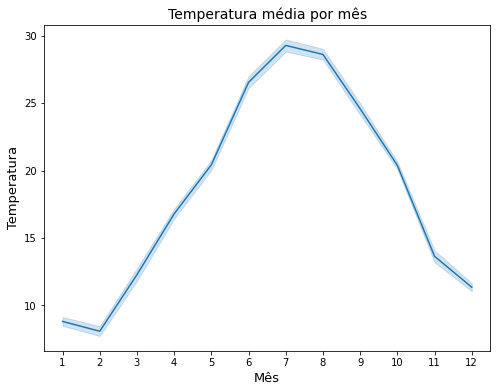

In [ ]:
# Distribuição por mês
plt.figure(figsize=(8,6))
ax = sns.lineplot(data=df3, x="Mês", y='T_x')
ax.set_xlim(0.5,12.5)
ax.set_xticks(range(1,13,1))
plt.title('Temperatura média por mês', fontsize=14)
plt.xlabel('Mês', fontsize=13)
plt.ylabel('Temperatura', fontsize=13);

Conforme gráfico da temperatura em função dos meses, observa-se que entre o mês de junho e agosto a temperatura apresenta valores elevados, característico da estação Verão. De forma complementar, nota-se queda na temperatura durante os meses de dezembro e janeiro, característico do Inverno. Relacionando estes dados, pode-se inferir que tais dados foram obtidos no hemisfério norte.

Portanto, a coluna com as estações do hemisfério Sul não contribuem para a análise deste dataset e será deletada.

#### Distribuição dos dados conforme a estação

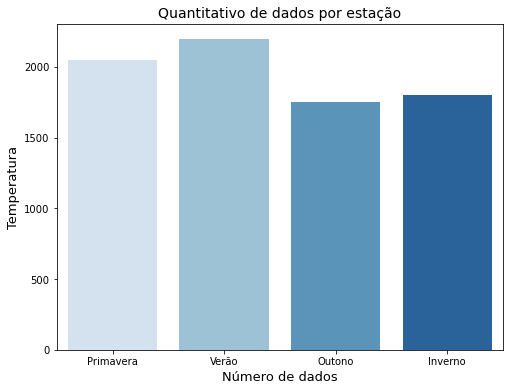

In [ ]:
# Quantidade de ocorrência de cada estação
plt.figure(figsize=(8,6))
x_order = ['Primavera', 'Verão', 'Outono', 'Inverno']
sns.countplot(data=df3, x='Estacoes_Norte', order = x_order, palette='Blues')
plt.title('Quantitativo de dados por estação', fontsize=14)
plt.xlabel('Número de dados', fontsize=13)
plt.ylabel('Temperatura', fontsize=13);

In [ ]:
df3.groupby('Estacoes_Norte')['Estacoes_Norte'].count()

Estacoes_Norte
Inverno      1802
Outono       1748
Primavera    2050
Verão        2195
Name: Estacoes_Norte, dtype: int64

Como apresentado, após os ajustes de data e remoção de outliers, os dados estão moderadamente balanceados entre as classes. O principal fator que originou essa diferença foi a exclusão de *outliers*, dado que as maiores variações dos dados ocorreram nessa época. A maior diferença, comparando Outono e Verão é de aproximadamente 18 dias (447 linhas de dados).

#### Identificação do valor de concentração de CO às quartas-feiras

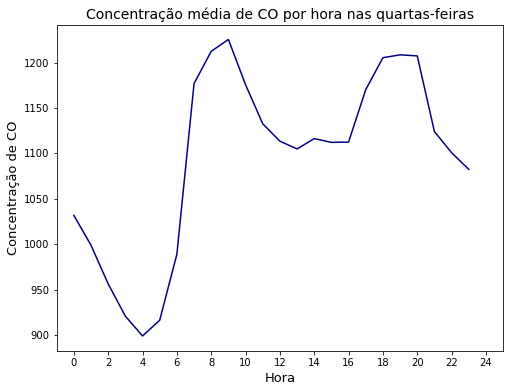

In [ ]:
# Agrupando os dados por dia, especificamente quarta-feira
df_quarta = pd.DataFrame(df3[df3['Dia da semana'] == 'Quarta-feira'].groupby(['Time'], as_index=True).agg('PT08.S1(CO)_x').mean())

#Visualização gráfica
plt.figure(figsize=(8,6))
ax = sns.lineplot(data=df_quarta, x='Time', y='PT08.S1(CO)_x', color='navy')
ax.set_xlim(-1,25)
ax.set_xticks(range(0,25,2))
plt.title('Concentração média de CO por hora nas quartas-feiras', fontsize=14)
plt.xlabel('Hora', fontsize=13)
plt.ylabel('Concentração de CO', fontsize=13);

Os 5 maiores valores médios de concentração de CO nas quartas-ferias é apresentado a seguir:

In [ ]:
df_quarta['PT08.S1(CO)_x'].nlargest()
#df_quarta['PT08.S1(CO)_x'].nsmallest()

Time
9     1225.388889
8     1212.355544
19    1208.484211
20    1207.290476
18    1205.297561
Name: PT08.S1(CO)_x, dtype: float64

Pode-se inferir que tais valores estão relacionados aos horários de maior tráfego, no qual usualmente há maior circulação de pessoas e automóveis pela manhã, que estão se direcionando para o trabalho, escola e outros afazeres. Após atingit o picos de concentração (~ 1245), inicia o decréscimo constante deste valor até as 13h e se mantém estável até às 16h, a partir do qual retoma uma elevada concentração de CO na atmosfera. Após às 22h novo decréscimo ocorre, atingindo o valor mínimo às 4h. 

#### Identificação do valor de concentração de CO ao longo do ano e estação

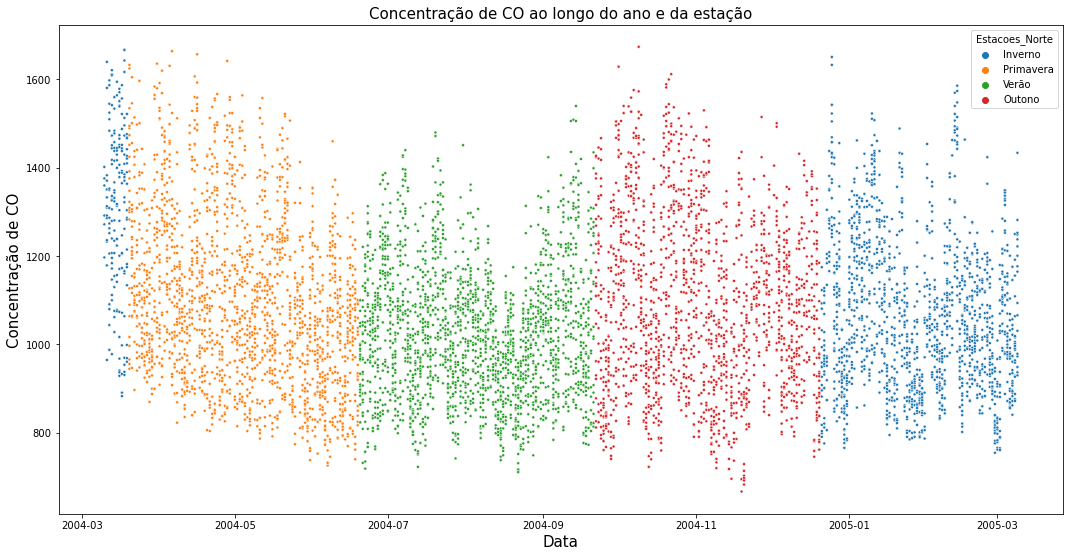

In [ ]:
# Distribuição por estação
plt.figure(figsize=(18,9))
a = sns.scatterplot(data=df3, x="Date",  y='PT08.S1(CO)_x', hue = 'Estacoes_Norte', marker='.')
plt.title('Concentração de CO ao longo do ano e da estação', fontsize=15)
plt.xlabel('Data', fontsize=15)
plt.ylabel('Concentração de CO', fontsize=15);

As maiores variações e concentração de CO são encontradas no período do inverno e os menores valores no verão. Isso é justificado pelas estações do ano a medida que no inverno a dispersão dos poluentes é prejudicada.

Interessante ressaltar que este comportamento também pode ser verificado para os demais poluentes. No entanto, o Ozônio apresenta maior concentração na primavera e verão dada a maior incidência de radiação solar, que favorece as reações fotoquímicas de formação deste poluente secundário.

### Série Temporal

Como adicional ao estudo, é apresentado para a variável PT08.S1(CO) a decomposição da série temporal em tendência, sazonalidade e resíduo.

In [ ]:
# Decomposição da série temporal
df4 = df3.groupby(pd.Grouper (key='Date')).mean()
decomposicao = seasonal_decompose(df4['PT08.S1(CO)_x'], model='additive', period=90 )

tendencia    = decomposicao.trend
sazonalidade = decomposicao.seasonal
residuo      = decomposicao.resid

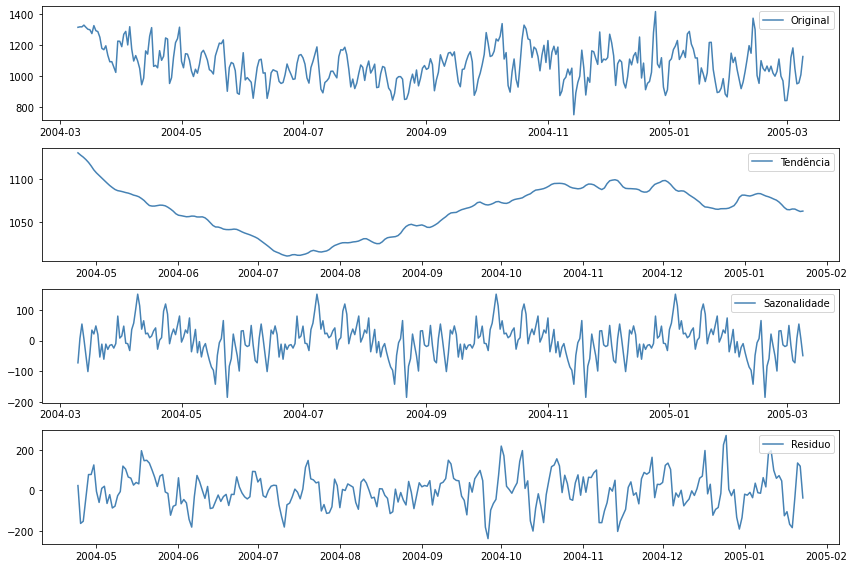

In [ ]:
# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(df4['PT08.S1(CO)_x'], label='Original', color="steelblue")
plt.legend(loc='upper right')

plt.subplot(412)
plt.plot(tendencia, label='Tendência', color="steelblue")
plt.legend(loc='upper right')

plt.subplot(413)
plt.plot(sazonalidade,label='Sazonalidade', color="steelblue")
plt.legend(loc='upper right')

plt.subplot(414)
plt.plot(residuo, label='Residuo', color="steelblue")
plt.legend(loc='upper right')
plt.tight_layout()

In [ ]:
df3.to_csv("df_tratado.csv", index = False, sep=',', encoding='utf-8', header=True)

## Machine Learning

Inicialmente, é necessário converter as variáveis categóricas para uma atributo numérico. Para tal, pode-se utilizar a função *get-dummies* do pandas. Também será realizada a conversão das variáveis de 'float' para 'int'.

In [ ]:
# Inclusão e visualização do dataset
df_ml = pd.read_csv('df_tratado.csv', parse_dates = ['Date'])

# Transformação da variável categórica Estacoes_Norte
df_ml = pd.get_dummies(df_ml, columns=['Estacoes_Norte'])
df_ml.head(5)

#Transformando os dados de float para int
df_ml[['PT08.S1(CO)_x', 'C6H6(GT)_x', 'PT08.S2(NMHC)_x', 'NOx(GT)_x', 'PT08.S3(NOx)_x', 'NO2(GT)_x', 
       'PT08.S4(NO2)_x', 'PT08.S5(O3)_x', 'T_x', 'RH_x', 'AH_x']] = df_ml[['PT08.S1(CO)_x', 
       'C6H6(GT)_x', 'PT08.S2(NMHC)_x', 'NOx(GT)_x', 'PT08.S3(NOx)_x', 'NO2(GT)_x', 'PT08.S4(NO2)_x',
       'PT08.S5(O3)_x', 'T_x', 'RH_x', 'AH_x']].astype('int')

A seleção das variáveis para o modelo de aprendizado de máquina é uma etapa importante, que resultará na qualidade do modelo. Para essa etapa foram avaliados os resultados da correlação de Pearson bem como simulações para obter resultados com melhores métricas de avaliação.

In [ ]:
# Definição de uma sigla e criação de uma lista para armazenar os dados modelos de machine learning

ada  = AdaBoostRegressor()
dt   = DecisionTreeRegressor()
gbm  = GradientBoostingRegressor()
knn  = KNeighborsRegressor()
lgbm = LightGBM()
lr   = LinearRegression()
rfr  = RandomForestRegressor()
svr  = SupportVectorRegressor()
xgb  = XGBRegressor()

ML = []

ML.append(('AdaBoostRegressor',ada))
ML.append(('DecisionTreeRegressor',dt))
ML.append(('GradientBoostingRegressor',gbm))          
ML.append(('KNeighborsRegressor',knn))
ML.append(('LightGBM',lgbm))   
ML.append(('LinearRegression',lr))          
ML.append(('RandomForestRegressor',rfr))          
ML.append(('SupportVectorRegressor',svr))
ML.append(('XGBRegressor',xgb))

#criando a funcao para calculo do MAPE
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
# Seleção das varíáveis independentes
features = ['PT08.S2(NMHC)_x', 'PT08.S3(NOx)_x', 'PT08.S4(NO2)_x', 'PT08.S5(O3)_x', 'NO2(GT)_x',
            'T_x', 'RH_x', 'AH_x', 'Dia', 'Mês', 'Ano',
            'Estacoes_Norte_Inverno','Estacoes_Norte_Outono', 'Estacoes_Norte_Primavera','Estacoes_Norte_Verão']

# Definição da variável dependente
target = ['PT08.S1(CO)_x']

X = df_ml[features]
y = df_ml[target]

# Separação dos dados em um conjunto de treino (70 %) e um conjunto de teste (30 %)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
print('Tamanho do dataset de treino:', X_train.shape)
print('Tamanho do dataset de teste: ', X_test.shape)

Tamanho do dataset de treino: (5456, 15)
Tamanho do dataset de teste:  (2339, 15)


In [ ]:
# Normalizaçõa dos dados 

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# Execução dos algorimos de ML e avaliação das métricas
MODELO = []
R2 = []
MSE = []
RMSE = []
RMSLE = []
MAE = []
MAPE = []

for ID,model in ML:
    print('', ID,'')
    print('\n')
    MODELO.append(ID)
            
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
        
    r2_score = metrics.r2_score(y_test, y_pred)
    R2.append(r2_score*100)
        
    mse_score = metrics.mean_squared_error(y_test, y_pred)
    MSE.append(mse_score)
        
    rmse_score = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    RMSE.append(rmse_score)
        
    rmsle_score = np.sqrt(metrics.mean_squared_log_error(y_test, y_pred))
    RMSLE.append(rmsle_score)
        
    mae_score = metrics.mean_absolute_error(y_test, y_pred)
    MAE.append(mae_score)
        
    mape_score = mean_absolute_percentage_error(y_test, y_pred)
    MAPE.append(mape_score)

 AdaBoostRegressor 


 DecisionTreeRegressor 


 GradientBoostingRegressor 


 KNeighborsRegressor 


 LightGBM 


 LinearRegression 


 RandomForestRegressor 


 SupportVectorRegressor 


 XGBRegressor 




In [ ]:
# Geração de um dataframe com os resultados das métricas obtidas pelos algoritmos de ML
df_metricas = pd.DataFrame({'Modelo': MODELO,
                         'R2' : R2,
                         'MAE' : MAE,
                         'MAPE' : MAPE,
                         'MSE' : MSE,
                         'RMSE' : RMSE,
                         'RMSLE' : RMSLE})

df_metricas.round(2)

,Modelo,R2,MAE,MAPE,MSE,RMSE,RMSLE
0,AdaBoostRegressor,86.98,53.54,18.92,4423.98,66.51,0.06
1,DecisionTreeRegressor,89.20,44.01,19.51,3669.24,60.57,0.05
2,GradientBoostingRegressor,93.30,36.53,19.16,2275.42,47.70,0.04
3,KNeighborsRegressor,93.42,34.36,3.11,2234.28,47.27,0.04
4,LightGBM,95.65,28.63,19.27,1478.54,38.45,0.03
5,LinearRegression,87.81,49.89,4.61,4141.72,64.36,0.06
6,RandomForestRegressor,94.56,31.72,19.20,1849.33,43.00,0.04
7,SupportVectorRegressor,78.06,60.75,16.69,7452.76,86.33,0.07
8,XGBRegressor,95.78,28.04,19.38,1432.90,37.85,0.03


Dentre as métricas existentes, a mais utilizada nesse tipo de modelagem é o RMSE - Raiz quadrada do erro-médio. De forma bem simplista, pode-se dizer que quanto menor este valor, melhor o modelo proposto.

Observando a tabela acima, temos que os modelos com melhores resultados foram: XGBRegressor, LightGBM e RandomForestRegressor, com erros de 5% se comparado ao menor valor registrado da concentração de CO. O coeficiente de correlação médio destes três modelos foi de r²=0,95. Para todos os modelos foi utilizado a configuração padrão.

Nesse ponto, acrescento que os resultados encontrados podem ser ajustados para valores ainda melhores com a adoção de etapas adicionais, como a validação cruzada e ajuste de hiperparâmetro. Estas não foram incluídas por questões de tempo e disponibilidade de processamento computacional.

In [ ]:
%watermark
%watermark --iversion

Last updated: 2021-01-19T19:59:15.107342-03:00

Python implementation: CPython
Python version       : 3.7.9
IPython version      : 7.19.0

Compiler    : MSC v.1916 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 58 Stepping 9, GenuineIntel
CPU cores   : 4
Architecture: 64bit

sklearn   : 0.24.0
missingno : 0.4.2
numpy     : 1.19.2
seaborn   : 0.11.1
pandas    : 1.2.0
pingouin  : 0.3.8
matplotlib: 3.3.2



---

<p style='text-align: right;'> <b> Danielle Calazans Dondoni </b></p>